# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

- Our business objective is to understand what features of a car eg. model, year, mileage, engine type, etc. that makes the car's value more or less expensive. The dealership would gain insight into which car specs they should prioritize when building their inventory that matters most to the customers. Understanding also these factors will maximize the profit margins of the car dealership. 

- Build a linear regression model to estimate the optimal value of used cars by validating a low RMSE - root mean square error. The analysis will also serve to inform future inventory decisions by highlighting the features most predictive of high selling price.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

- Load the dataset to visually see the dataframe
- Get the information of the vehicle dataset ie. number of rows/columns, shape, data types
- Identify column names and data types, identify numeric and non-numeric data
- Identify missing NaN values
- Calculate percentage of missing values
- Prepare a plan to handle missing values by dropping or imputing(replacing values by mean/meadian/'unknown')
- Identify duplicate- Inspect each features value
- Create a visual plot for feature distribution

---

### Sections

- [Data Preparation](#Data-Preparation)
- [Train Test Split](#Train-Test-Split)
- [Modeling](#Modeling)
- [Ordinary Least Squares (OLS) Linear Regression](#Ordinary-Least-Squares-(OLS)-Linear-Regression)
- [Ridge Regression and GridSearch](#Ridge-Regression-and-GridSearch)
- [Lasso Regression and GridSearch](#Lasso-Regression-and-GridSearch)
  

**Transformers / Encoders:**
- SimpleImputer()
- StandardScaler()
- PolynomialFeatures()
- FunctionTransformer() #(np.log1p, validate=True)
- StandardScaler()
- PolynomialFeatures(degree=3, include_bias=False) #numerical
- OneHotEncoder()
- OrdinalEncoder()
- TargetEncoder()

In [1]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")


# Category Encoders Library - you have to pip install before usage, alternate for sklearn
# from category_encoders import TargetEncoder

import pandas as pd
import numpy as np

from datetime import datetime
import time     #to debug execution time / hangs

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

# Use this to ignore ALL ImportWarnings globally
warnings.filterwarnings("ignore", category=ImportWarning)



In [2]:
# Vehicle data
auto = pd.read_csv('data/vehicles.csv')

# Update columns: remove spaces and lowercase
auto.columns = auto.columns.str.replace(' ', '_')    #if any spaces
auto.columns = auto.columns.str.lower()

In [3]:
# Get the shape - number of rows and columns
# column names and data types
auto.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  vin           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
auto.describe().T

# Note that there are only few numerical features to show on this table

,count,mean,std,min,25%,50%,75%,max
id,426880.0,7.311487e+09,4.473170e+06,7.207408e+09,7.308143e+09,7.312621e+09,7.315254e+09,7.317101e+09
price,426880.0,7.519903e+04,1.218228e+07,0.000000e+00,5.900000e+03,1.395000e+04,2.648575e+04,3.736929e+09
year,425675.0,2.011235e+03,9.452120e+00,1.900000e+03,2.008000e+03,2.013000e+03,2.017000e+03,2.022000e+03
odometer,422480.0,9.804333e+04,2.138815e+05,0.000000e+00,3.770400e+04,8.554800e+04,1.335425e+05,1.000000e+07


In [5]:
auto.head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [6]:
auto.tail(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


In [7]:
# Get the shape
auto.shape

(426880, 18)

**Dataset Columns**


In [8]:
# Numerical features
auto_numeric = auto.select_dtypes(include="number")
print("Numeric Features: ", auto_numeric.shape[1] )
print("Numeric Columns: ", auto_numeric.columns.tolist())
# List:  ['id', 'price', 'year', 'odometer']

print()

# Non-Numerical features
auto_non_numeric = auto.select_dtypes(include="object")
print("Non-Numeric Features: ", auto_non_numeric.shape[1]) 
print("Non-Numeric Columns: ", auto_non_numeric.columns.tolist())
# List: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'state']

Numeric Features:  4
Numeric Columns:  ['id', 'price', 'year', 'odometer']

Non-Numeric Features:  14
Non-Numeric Columns:  ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'state']


**Quick DataFrame Summary:**
- Total rows = 426880
- Total columns = 18
- Shape = (426880, 18)
- Numeric Features:  4
- Non-Numeric Features:  14
- **Columns:** 
  'id', 'price', 'year', 'odometer', 'region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'state' 

**Identify missing values**

In [9]:
# Total missing values
auto['size'].isna().sum()

np.int64(306361)

In [10]:
# Identify all columns with missing values
auto.isna().sum().sort_values(ascending=True)


id                   0
price                0
state                0
region               0
year              1205
transmission      2556
fuel              3013
odometer          4400
model             5277
title_status      8242
manufacturer     17646
type             92858
paint_color     130203
drive           130567
vin             161042
condition       174104
cylinders       177678
size            306361
dtype: int64

**Columns that have no missing values**
- id, region, price, state

**Calculate percentage of missing values per column:**

In [11]:
# Calculate missing percentage 
missing_value_percent= (auto.isna().sum().sort_values(ascending=True) / len(auto) * 100 ).round(3)
missing_value_percent


id               0.000
price            0.000
state            0.000
region           0.000
year             0.282
transmission     0.599
fuel             0.706
odometer         1.031
model            1.236
title_status     1.931
manufacturer     4.134
type            21.753
paint_color     30.501
drive           30.586
vin             37.725
condition       40.785
cylinders       41.622
size            71.767
dtype: float64

**Missing Percent Results**
- Size is the highest column with missing values
- Cylinders, condition, drive, paint_color, type are also have a high estimated missing values - recommended for imputation
  
**Columns recommended to drop**
-In general, missing values greater than 60-70% treshold are recommended to be drop.

Columsn to drop:
- ID column  - unique identfier
- VIN number  - unique identifier
- Size

### Explore size


In [12]:
auto_size = auto['size'].value_counts().sort_values(ascending=True).reset_index()
auto_size


,size,count
0,sub-compact,3194
1,compact,19384
2,mid-size,34476
3,full-size,63465


In [13]:
# Define color scheme for bar plot
color_scheme = ['blue', 'orange', 'green', 'red','lightgreen', 'skyblue', 'silver','gold', 'purple', 'brown', 'gray','olive', 'cyan']

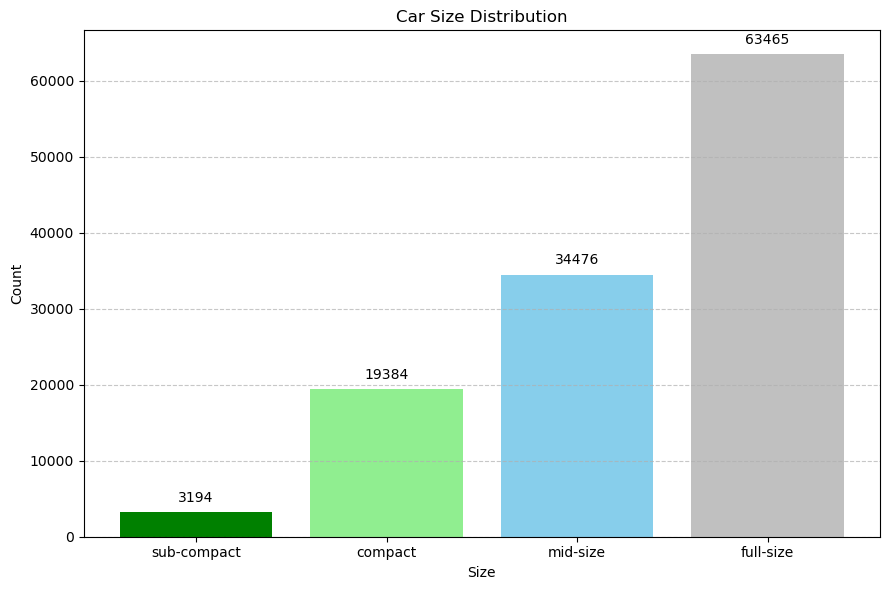

In [14]:
# Bar plot
plt.figure(figsize = (9, 6))
plt.bar(auto_size['size'], auto_size['count'], color = ['green','lightgreen', 'skyblue', 'silver',"gold"])

# Add labels and title
plt.title('Car Size Distribution')
plt.xlabel('Size'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_size['count']):
    plt.text(i, count + 1000, f'{count}', ha = 'center', va = 'bottom', fontsize = 10)

# Add grid lines for better readability
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Explore cylinders

In [15]:
auto_cylinders = auto['cylinders'].value_counts().sort_values(ascending=True).reset_index()
auto_cylinders

,cylinders,count
0,12 cylinders,209
1,3 cylinders,655
2,other,1298
3,10 cylinders,1455
4,5 cylinders,1712
5,8 cylinders,72062
6,4 cylinders,77642
7,6 cylinders,94169


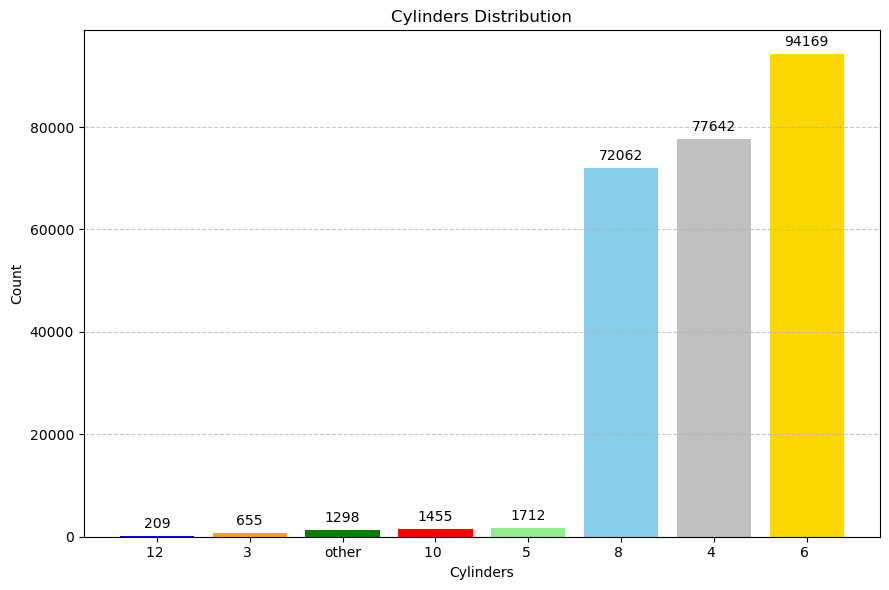

In [16]:
# Bar plot
# Drop 'cylinders' text
auto_cylinders['cylinders'] = auto_cylinders['cylinders'].str.replace('cylinders', '', regex=False)

plt.figure(figsize=(9, 6))
plt.bar(auto_cylinders['cylinders'], auto_cylinders['count'], color= color_scheme)

# Add labels and title
plt.title('Cylinders Distribution')
plt.xlabel('Cylinders'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_cylinders['count']):
    plt.text(i, count + 1000, f'{count}', ha='center', va='bottom', fontsize=10)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Explore condition

In [17]:
auto_condition = auto['condition'].value_counts().sort_values(ascending=True).reset_index()
auto_condition

,condition,count
0,salvage,601
1,new,1305
2,fair,6769
3,like new,21178
4,excellent,101467
5,good,121456


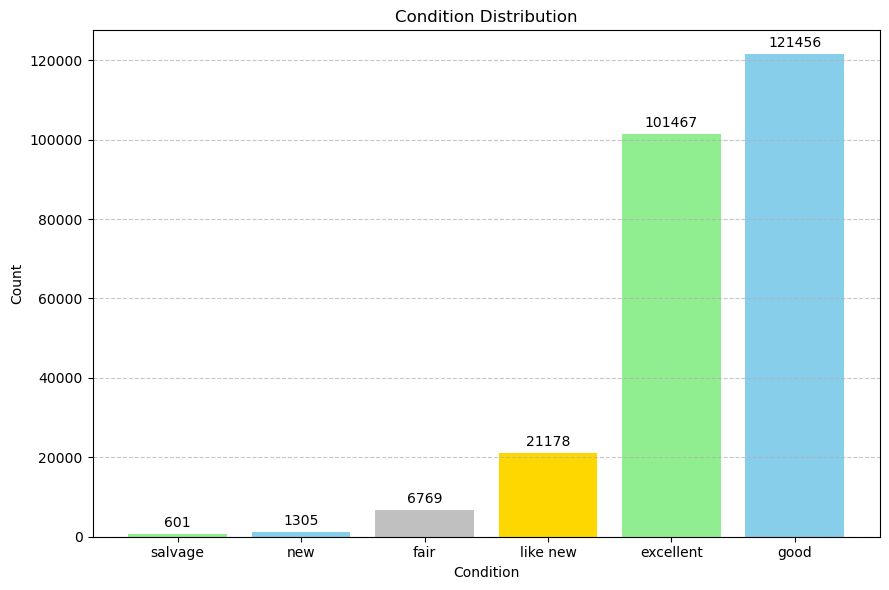

In [18]:
# Bar plot
plt.figure(figsize=(9, 6))
plt.bar(auto_condition['condition'], auto_condition['count'], color=['lightgreen', 'skyblue', 'silver',"gold"])

# Add labels and title
plt.title('Condition Distribution')
plt.xlabel('Condition'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_condition['count']):
    plt.text(i, count + 1000, f'{count}', ha='center', va='bottom', fontsize=10)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect drive train

In [19]:
auto_drive = auto['drive'].value_counts().sort_values(ascending=True).reset_index()
auto_drive

,drive,count
0,rwd,58892
1,fwd,105517
2,4wd,131904


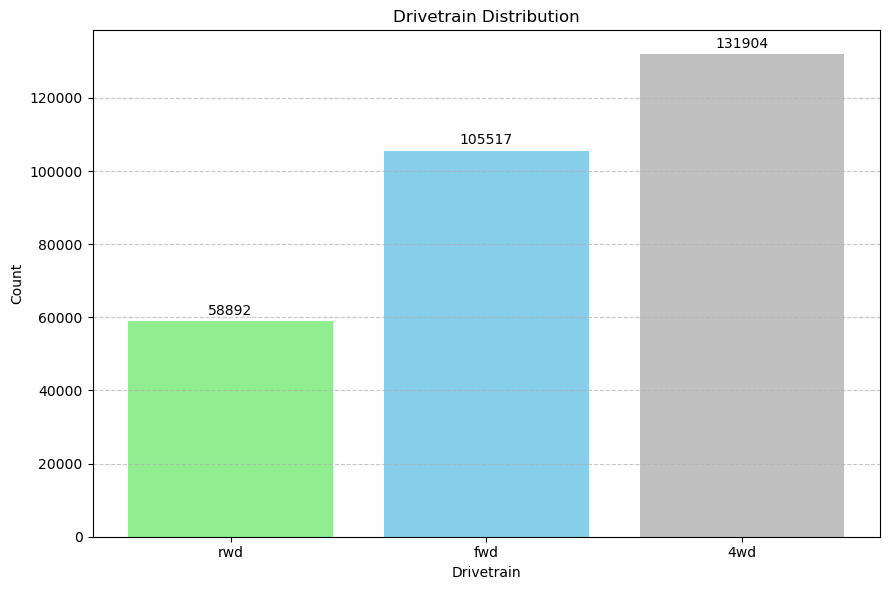

In [20]:
# Bar plot
plt.figure(figsize=(9, 6))
plt.bar(auto_drive['drive'], auto_drive['count'], color=['lightgreen', 'skyblue', 'silver',"gold"])

# Add labels and title
plt.title('Drivetrain Distribution')
plt.xlabel('Drivetrain'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_drive['count']):
    plt.text(i, count + 1000, f'{count}', ha='center', va='bottom', fontsize=10)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect paint_color

In [21]:
auto_paint_color = auto['paint_color'].value_counts().sort_values(ascending=True).reset_index()
auto_paint_color

,paint_color,count
0,purple,687
1,orange,1984
2,yellow,2142
3,brown,6593
4,custom,6700
5,green,7343
6,grey,24416
7,red,30473
8,blue,31223
9,silver,42970


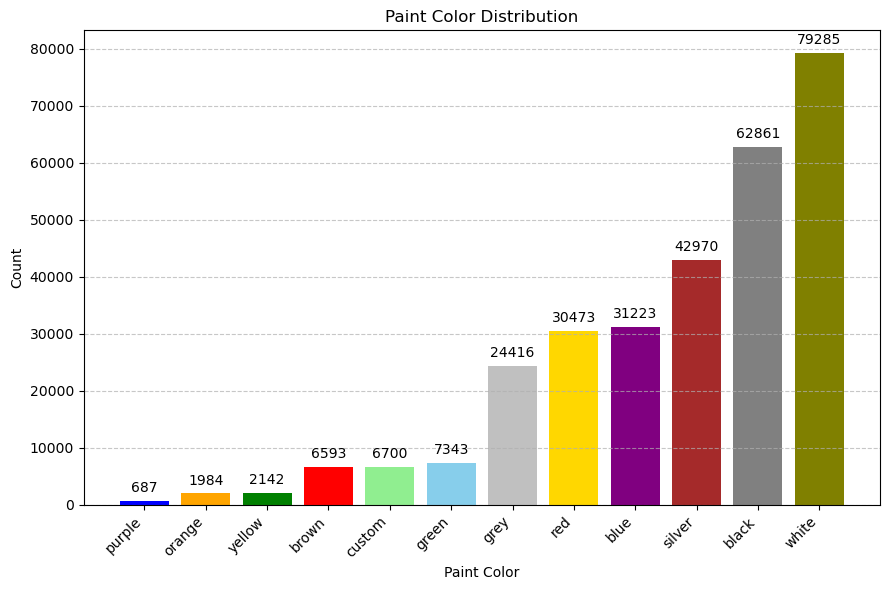

In [22]:
# Bar plot
plt.figure(figsize=(9, 6))
plt.bar(auto_paint_color['paint_color'], auto_paint_color['count'], color=color_scheme)

# Add labels and title
plt.title('Paint Color Distribution')
plt.xlabel('Paint Color'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_paint_color['count']):
    plt.text(i, count + 1000, f'{count}', ha='center', va='bottom', fontsize=10)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
#Rotate the X-axis tick labels by 45 degrees
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect type

In [23]:
auto_type = auto['type'].value_counts().sort_values(ascending=True).reset_index()
auto_type


,type,count
0,bus,517
1,offroad,609
2,mini-van,4825
3,convertible,7731
4,van,8548
5,wagon,10751
6,hatchback,16598
7,coupe,19204
8,other,22110
9,truck,35279


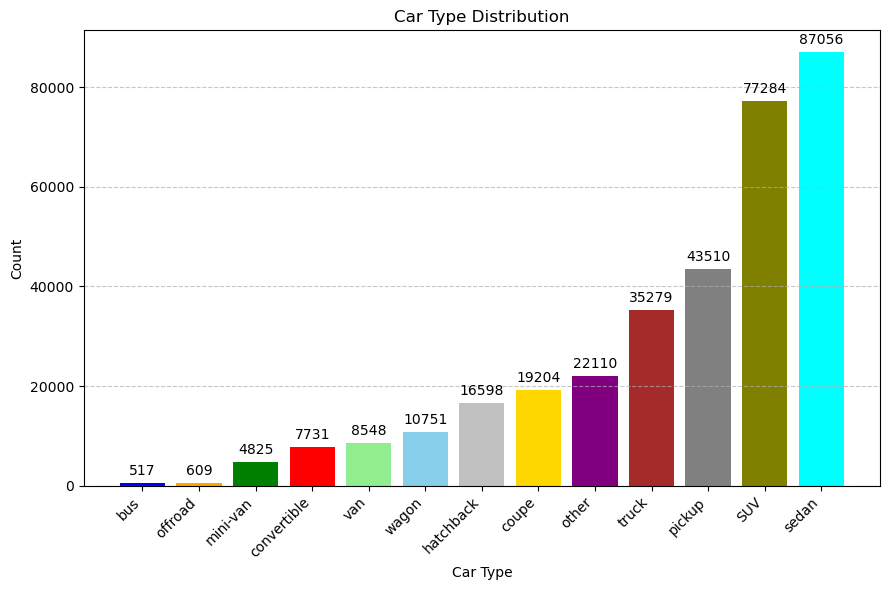

In [24]:
# Bar plot
plt.figure(figsize=(9, 6))
plt.bar(auto_type['type'], auto_type['count'], color=color_scheme)

# Add labels and title
plt.title('Car Type Distribution')
plt.xlabel('Car Type'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_type['count']):
    plt.text(i, count + 1000, f'{count}', ha = 'center', va = 'bottom', fontsize = 10)

# Add grid lines for better readability
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
# Rotate the X-axis tick labels by 45 degrees
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect title_status

In [25]:
auto_title_status = auto['title_status'].value_counts().sort_values(ascending = True).reset_index()
auto_title_status


,title_status,count
0,parts only,198
1,missing,814
2,lien,1422
3,salvage,3868
4,rebuilt,7219
5,clean,405117


In [26]:
# Percentage of title status
total_title = auto['title_status'].value_counts().sum()
print( (auto['title_status'].value_counts()/total_title) * 100)

title_status
clean         96.770241
rebuilt        1.724402
salvage        0.923949
lien           0.339673
missing        0.194440
parts only     0.047296
Name: count, dtype: float64


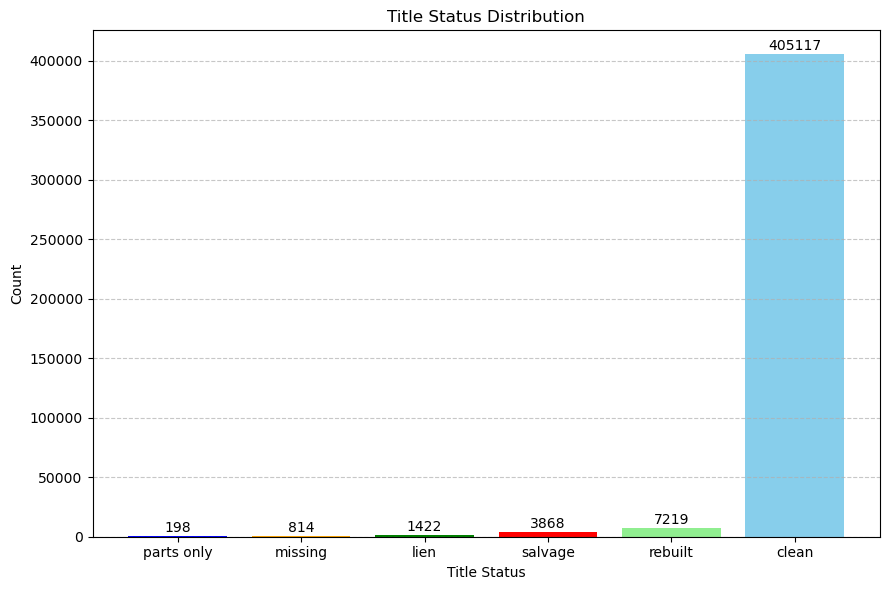

In [27]:
# Bar plot
plt.figure(figsize = (9, 6))
plt.bar(auto_title_status['title_status'], auto_title_status['count'], color = color_scheme)

# Add labels and title
plt.title('Title Status Distribution')
plt.xlabel('Title Status'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_title_status['count']):
    plt.text(i, count + 1000, f'{count}', ha = 'center', va = 'bottom', fontsize = 10)

# Add grid lines for better readability
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect transmission

In [28]:
auto_transmission = auto['transmission'].value_counts().sort_values(ascending = True).reset_index()
auto_transmission


,transmission,count
0,manual,25118
1,other,62682
2,automatic,336524


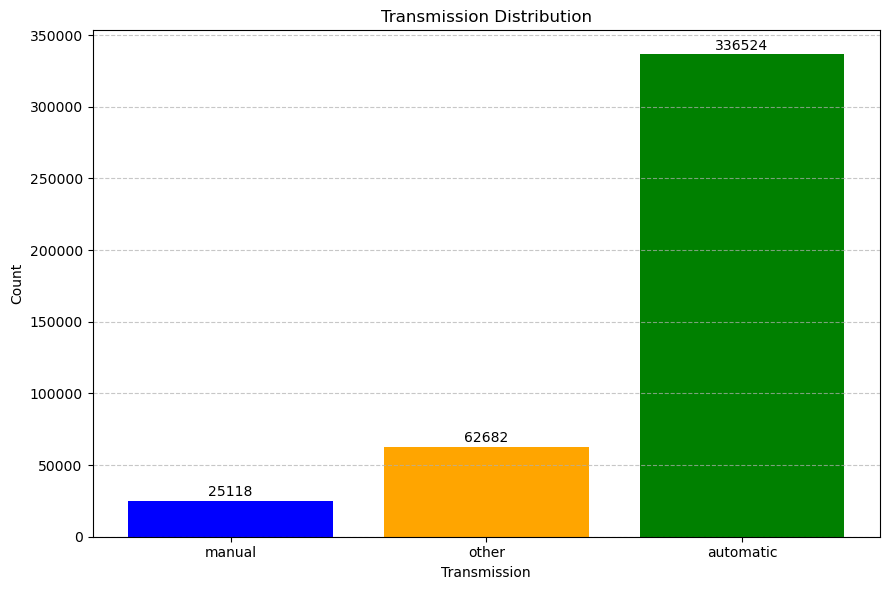

In [29]:
# Bar plot
plt.figure(figsize = (9, 6))
plt.bar(auto_transmission['transmission'], auto_transmission['count'], color = color_scheme)

# Add labels and title
plt.title('Transmission Distribution')
plt.xlabel('Transmission'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_transmission['count']):
    plt.text(i, count + 1000, f'{count}', ha = 'center', va = 'bottom', fontsize = 10)

# Add grid lines for better readability
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect fuel type

In [30]:
auto_fuel = auto['fuel'].value_counts().sort_values(ascending = True).reset_index()
auto_fuel

,fuel,count
0,electric,1698
1,hybrid,5170
2,diesel,30062
3,other,30728
4,gas,356209


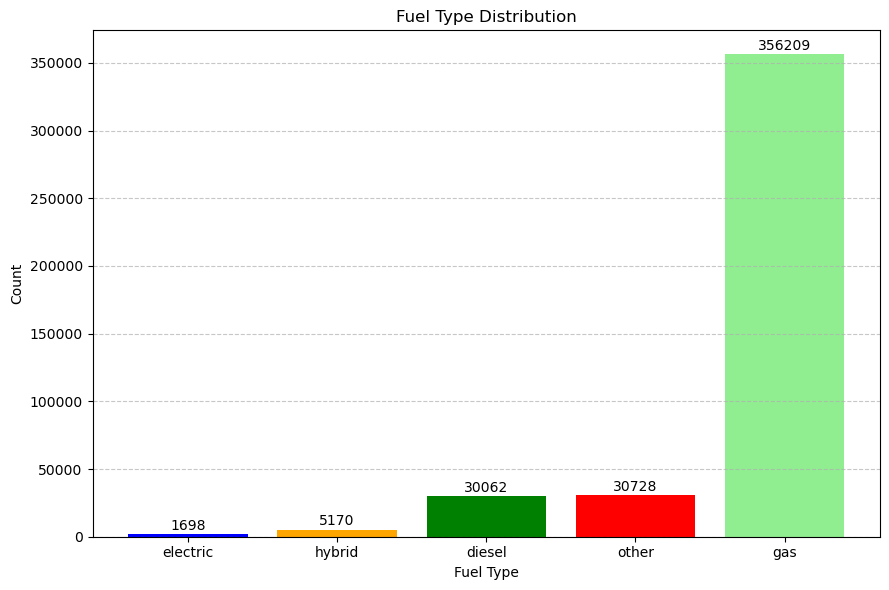

In [31]:
# Bar plot
plt.figure(figsize = (9, 6))
plt.bar(auto_fuel['fuel'], auto_fuel['count'], color = color_scheme)

# Add labels and title
plt.title('Fuel Type Distribution')
plt.xlabel('Fuel Type'); plt.ylabel('Count')

# Add value labels on top of the bars
for i, count in enumerate(auto_fuel['count']):
    plt.text(i, count + 1000, f'{count}', ha = 'center', va = 'bottom', fontsize = 10)

# Add grid lines for better readability
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect manufacturer

In [32]:
auto_manufacturer = auto['manufacturer'].value_counts().sort_values(ascending = True).reset_index()
#auto_manufacturer

#multi-values

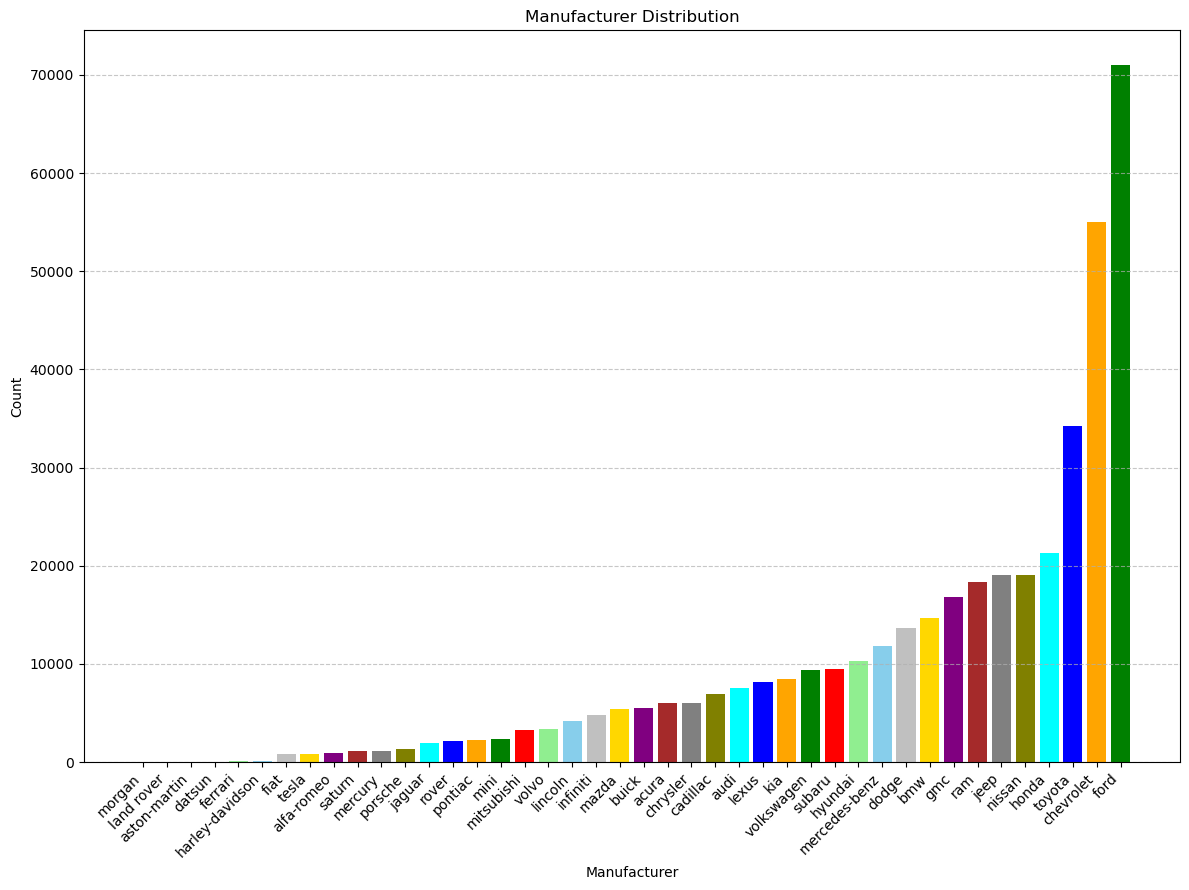

In [33]:
# Bar plot
plt.figure(figsize = (12, 9))
plt.bar(auto_manufacturer['manufacturer'], auto_manufacturer['count'], color = color_scheme)

# Add labels and title
plt.title('Manufacturer Distribution')
plt.xlabel('Manufacturer'); plt.ylabel('Count')

# Add value labels on top of the bars
# disable high cardinal
#for i, count in enumerate(auto_manufacturer['count']):
#    plt.text(i, count + 1000, f'{count}', ha = 'center', va = 'bottom', fontsize = 10)

# Add grid lines for better readability
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
# Rotate the X-axis tick labels by 45 degrees
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect model

In [34]:
auto_model = auto['model'].value_counts().head(50).sort_values(ascending = True).reset_index()
auto_model.tail(10)

,model,count
40,escape,2746
41,altima,2779
42,civic,2799
43,wrangler,2848
44,accord,2969
45,silverado,3023
46,camry,3135
47,1500,4211
48,silverado 1500,5140
49,f-150,8009


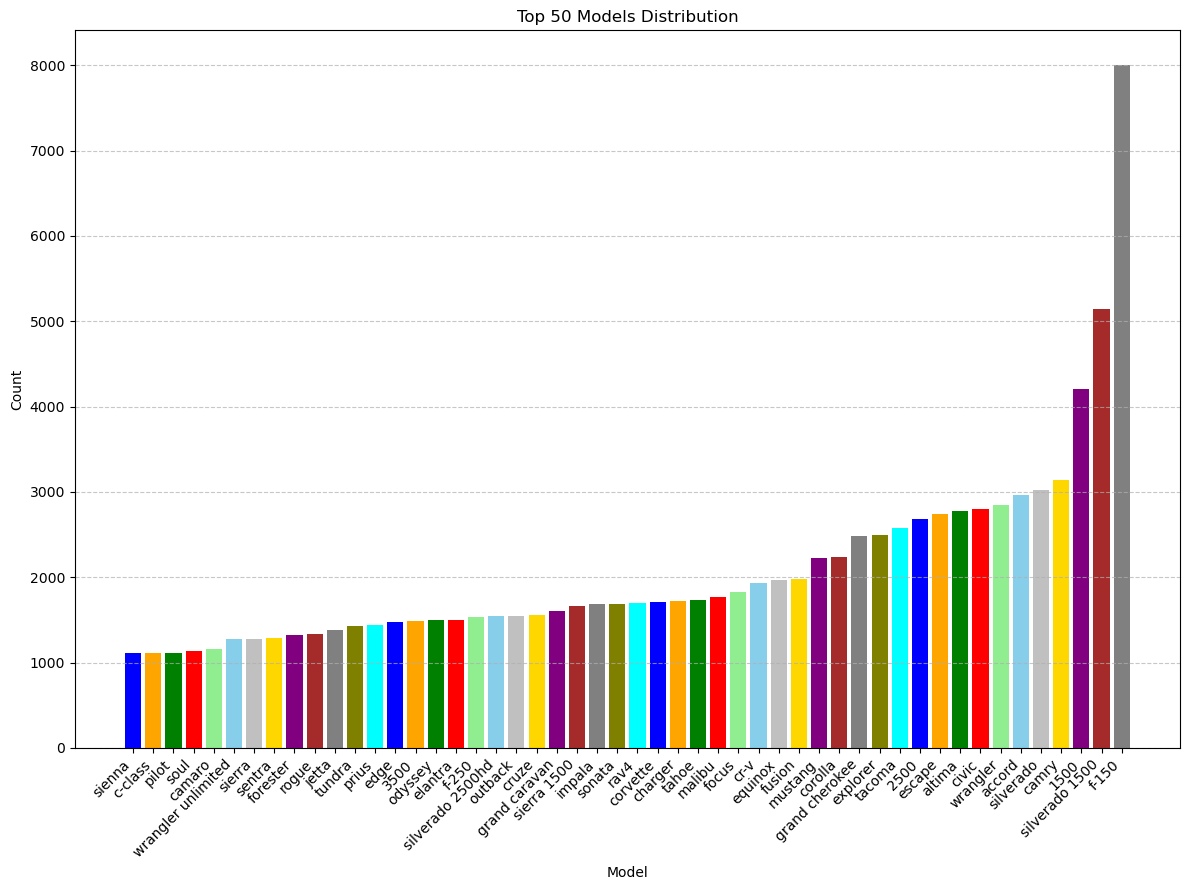

In [35]:
# Bar plot
plt.figure(figsize = (12, 9))
plt.bar(auto_model['model'], auto_model['count'], color = color_scheme)

# Add labels and title
plt.title('Top 50 Models Distribution')
plt.xlabel('Model'); plt.ylabel('Count')

# Add value labels on top of the bars
# disable high cardinal
#for i, count in enumerate(auto_model['count']):
#    plt.text(i, count + 1000, f'{count}', ha = 'center', va = 'bottom', fontsize = 10)

# Add grid lines for better readability
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
# Rotate the X-axis tick labels by 45 degrees
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

### Inspect odometer

In [36]:
auto_odometer = auto['odometer'].value_counts().sort_values(ascending = True).reset_index()
auto_odometer.sample(n  = 10)

,odometer,count
53625,9719.0,2
50573,139455.0,2
39931,49430.0,1
98604,31140.0,9
4243,17289.0,1
77549,29208.0,3
83925,211051.0,4
11915,113274.0,1
30912,13018.0,1
45470,94289.0,1


In [37]:
# Calculate the skewness of the 'odometer' column
skew_value = auto['odometer'].skew()
skew_value.round(2)

np.float64(38.04)

* the odometer distribution is severely right-skewed

### Inspect year

In [38]:
auto_year = auto['year'].astype('Int64').value_counts().sort_values(ascending = True).reset_index()
auto_year.tail(5)


,year,count
109,2016,30434
110,2013,30794
111,2015,31538
112,2018,36369
113,2017,36420


In [39]:
min_year = auto['year'].min()
max_year = auto['year'].max()

print(f"Minimum Year: {min_year}")
print(f"Maximum Year: {max_year}")

Minimum Year: 1900.0
Maximum Year: 2022.0


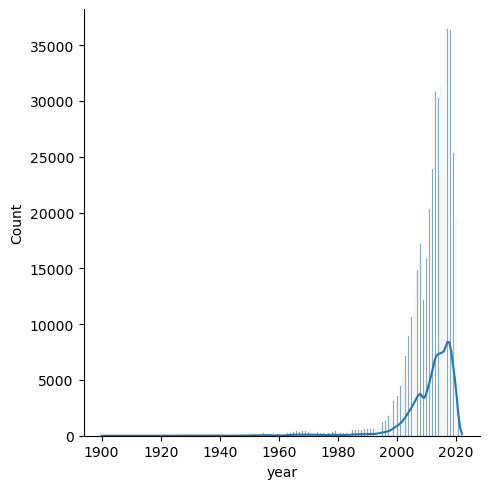

In [40]:
sns.displot( auto['year'], kde = True,  ) #rug = True

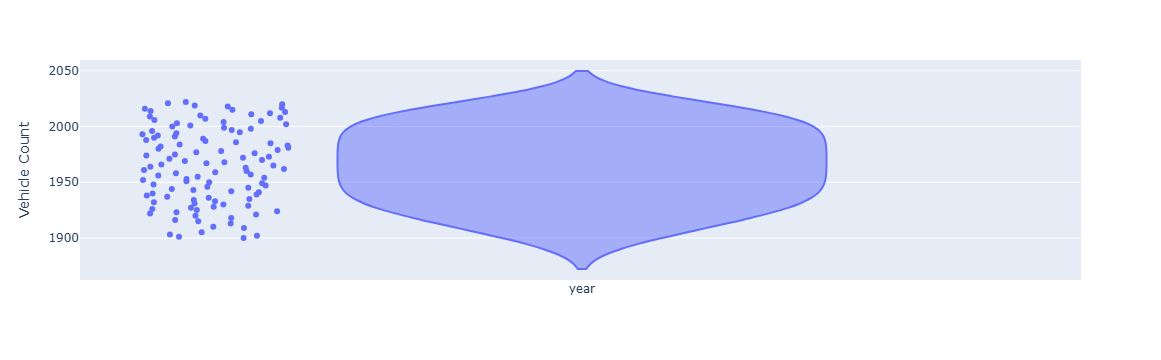

In [41]:
fig = px.violin( auto_year['year'], points = 'all', labels = ("Year", "Count"))
fig.update_layout( xaxis_title=" ", yaxis_title="Vehicle Count")

- Majority of the car distribution is between the year of 2000 - 2022 as shown in the histogram. The distribution is left skewed.

- The widest part of the violin plot is between 1950 and 2000 indicating that the majority of the data points falls within this range.

[Go to Top](#Sections)

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

- Data Cleaning
- Replacing and renaming text
- Dropping duplicates
- Dropping unique identifiers - no statistical power
- Dropping features with extreme missing NaN values
- Column transformation example car year to car age
- Imputation - replacing missing values with 'unknown', mean, median, mode
- Encoding - converting string objects to numerics using encoders
- Apply Log-transformation


**Data Cleaning**
- When dropping duplicates, be cautious with data collapse, and duplicates will emerge
  

In [43]:
auto.head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


- Drop rows where all values in these columns are NaN 

In [44]:
# columns_nan = ['price','year','manufacturer','model','condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']

# Mask and save rows with multi NaN columns
nan_rows = auto.iloc[:27]

# Drop first 27 rows with high NaN_columns
auto = auto.drop(index=list(range(27)))

# Reset the index to make it back to sequential
auto = auto.reset_index(drop=True)

In [45]:
# Replace text on cylinders for later ordinal transformation

auto['cylinders'] = auto['cylinders'].str.replace(' cylinders', '', regex=False)
auto['cylinders'].unique()

array(['8', '6', nan, '4', '5', 'other', '3', '10', '12'], dtype=object)

In [46]:
# Duplicates 
auto.duplicated().sum()

# auto.drop_duplicates(inplace=True)     # drop due to data collapse

np.int64(0)

In [47]:
# Missing Values on Feature Columns
print((auto.isnull().sum() / len(auto) ) * 100)


id               0.000000
region           0.000000
price            0.000000
year             0.275973
manufacturer     4.127651
model            1.229932
condition       40.781487
cylinders       41.618777
fuel             0.699538
odometer         1.024474
title_status     1.924550
transmission     0.592476
vin             37.721417
drive           30.581957
size            71.765690
type            21.747768
paint_color     30.496682
state            0.000000
dtype: float64


In [48]:
# Drop columns
# VIN is a unique identifier. It has little predictive power for price.
# ID - unique identifier.
# Size is 71% missing values. Higlyly bias to impute mode/'unknown'.

# To drop, df.drop_duplicates() # To count, auto.duplicated(keep=False).sum()

auto.drop(columns=['id', 'vin', 'size'], inplace = True) #,'size'

# Use Align y_train if dropping after train-split to sync
# y_train = y_train.loc[X_train.index]

In [49]:
auto.duplicated().sum() 

# 56482+- duplicates may emerge on data collapse

np.int64(56482)

In [50]:
# Remove duplicates
# After dropping the ID and VIN, it will reveal duplicates 
# because it is masking the data with unique ID after the data collapse

auto = auto.drop_duplicates()     #remove the duplicates
auto = auto.reset_index(drop=True)
auto.duplicated().sum()

np.int64(0)

In [51]:
# Car Year Conversion to Car Age
# Convert car's year to car_age / Feature Engineering
# This creates a new car_age column and drop the old year column, and year is already in float datatype

current_year = datetime.now().year
auto['car_age'] = current_year - auto['year']

# Drop the car year column( now duplicate)
auto.drop(columns=['year'], inplace=True)


In [52]:
# Verify info before splitting the data
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370371 entries, 0 to 370370
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        370371 non-null  object 
 1   price         370371 non-null  int64  
 2   manufacturer  355170 non-null  object 
 3   model         365707 non-null  object 
 4   condition     229231 non-null  object 
 5   cylinders     219725 non-null  object 
 6   fuel          367952 non-null  object 
 7   odometer      366943 non-null  float64
 8   title_status  363692 non-null  object 
 9   transmission  368353 non-null  object 
 10  drive         257984 non-null  object 
 11  type          291565 non-null  object 
 12  paint_color   261734 non-null  object 
 13  state         370371 non-null  object 
 14  car_age       369403 non-null  float64
dtypes: float64(2), int64(1), object(12)
memory usage: 42.4+ MB


In [53]:
#Use IQR to exclude high price cars outliers above upper fence
Q1 = auto['price'].quantile(0.25)
Q3 = auto['price'].quantile(0.75)
IQR = Q3 - Q1

# Calculate Upper Fence
price_limit = Q3 + 1.5 * IQR    #(1.5 * IQR standard rule)
price_lower = Q1 - 1.5 * IQR

print(f"Q1: ${Q1:,.2f}")
print(f"Q3: ${Q3:,.2f}")
print(f"IQR Upper Threshold (Price): ${price_limit:,.2f}")
print(f"IQR Lower Threshold (Price): ${price_lower:,.2f}")

## 58,482.50

Q1: $5,995.00
Q3: $26,990.00
IQR Upper Threshold (Price): $58,482.50
IQR Lower Threshold (Price): $-25,497.50


In [54]:
# For extreme expensive cars or outliers, exclude them
# The most expensive car in 2025 is about 30M

# Remove outliers greater than the upper limit and price equal or below zero
outliers_high_end = len(auto[ auto['price'] > price_limit])
outliers_low_end = len(auto[auto['price'] <= 0])
print("Removing outliers cars more than: ", price_limit, " :", outliers_high_end,  outliers_low_end)



Removing outliers cars more than:  58482.5  : 6823 25681


In [55]:
# Overwrite auto with the filtered results
auto_keep = (auto['price'] <= price_limit)    # prices below limit, returns boolean
auto = auto[auto_keep]                        # resave to auto

auto.shape

(363548, 15)

In [56]:
# Remove zero and negative price outliers
auto_keep = (auto['price'] > 0)
auto = auto[auto_keep]
auto.shape

(337867, 15)

In [57]:
# Verify:  should be zero - outliers removed
auto[auto['price'] > price_limit] 
(auto['price'] > price_limit).sum()

np.int64(0)

In [58]:
# Verify:  should be zero - outliers removed
auto[auto['price'] <= 0] 
(auto['price'] <= 0).sum()

np.int64(0)

[Go to Top](#Sections)

### Train Test Split
- Golden Rule - Fit on Train, Transform on Test


In [59]:
X = auto.drop(['price'], axis = 1)   #all features to use
y = auto['price']                    #feature to predict, apply log later on

# Set test size to 20-30% for large 426k dataset (trial %10 issue)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)    

print("X_train y_train shape: ", X_train.shape, y_train.shape)    
print("X_test y_test shape: ", X_test.shape, y_test.shape) 


# Copy original and if needed for logarithmic inverse
y_train_orig = y_train
y_test_orig = y_test

X_train y_train shape:  (270293, 14) (270293,)
X_test y_test shape:  (67574, 14) (67574,)


### Baseline metrics

In [60]:
# Create a baseline MSE/RMSE from X train

# Create an array with shape and fill test values with y_train mean price
avg_price = y_train.mean()

y_pred_baseline = np.full( shape = y_test.shape, fill_value = avg_price )

mse_baseline = mean_squared_error(y_test, y_pred_baseline)

rmse_baseline = np.sqrt(mse_baseline)

#print(f"MSE Baseline: {mse_baseline:,.2f}")

print("Baseline Price Metrics:")
print(f"RMSE Baseline: {rmse_baseline:,.2f}")

print()

# Baseline Mean and Median price for both y_train and y_test are same
y_train_median_price = y_train.median()
print(f"y_train Base Median Price: ${y_train_median_price:,.2f}" )
y_train_mean_price = y_train.mean()
print(f"y_train Base Mean Price: ${y_train_mean_price:,.2f}" )


# Raw Data
#RMSE Train: 12,800,841.99
#RMSE Test: 13,699,378.21

Baseline Price Metrics:
RMSE Baseline: 12,854.99

y_train Base Median Price: $15,000.00
y_train Base Mean Price: $18,000.65


- The mean is higher than the median indicating that the data is right-skewed.

In [61]:
y_train.describe()

count    270293.000000
mean      18000.653532
std       12817.594864
min           1.000000
25%        7000.000000
50%       15000.000000
75%       26995.000000
max       58444.000000
Name: price, dtype: float64

### Log transformation to target variable


In [62]:
# Apply Log Transform to target variable after split to avoid data leakage
# np.log1p ( is log(x + 1) ) - handles any $0 prices without error

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# New median/mean (much smaller, manageable number)
print(f"Log-transformed y_train mean: {y_train_log.mean():,.4f}")
print(f"Log-transformed y_test mean: {y_test_log.mean():,.4f}")


Log-transformed y_train mean: 9.4108
Log-transformed y_test mean: 9.4110


Text(0.5, 1.0, 'Price Distribution (Log Transformed)')

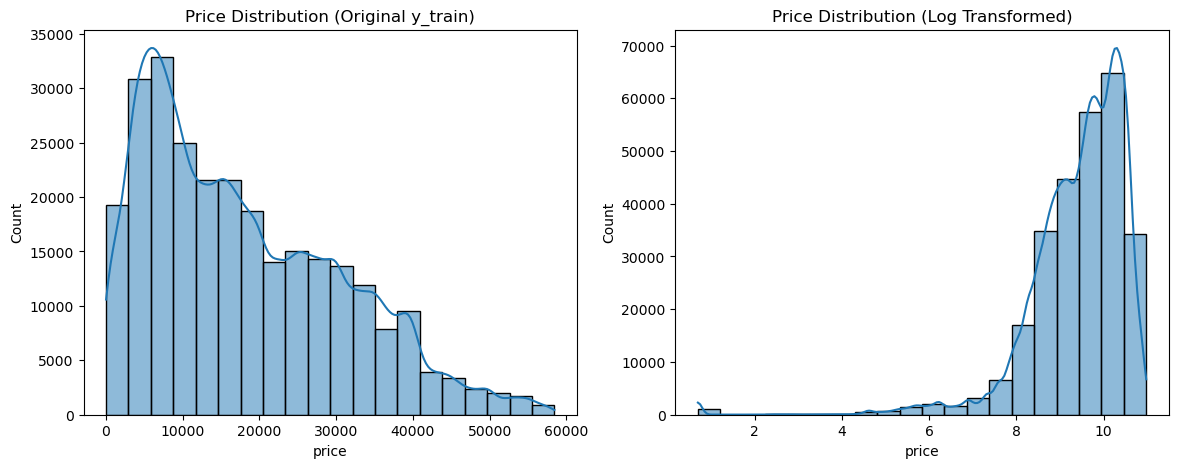

In [63]:
# Plot price / price log comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Original Price Distribution
sns.histplot(y_train_orig, kde=True, bins=20, ax=ax[0]) 
# Set the title and labels using the Matplotlib axis object
ax[0].set_title('Price Distribution (Original y_train)')

# Plots the histogram and the smooth KDE line on the second subplot
sns.histplot(y_train_log, kde=True, bins=20, ax=ax[1])
ax[1].set_title('Price Distribution (Log Transformed)')



- The histogram of the original (y_train) price distribution is heavily right-skewed, most cars are clustered at the lower-price end, and a long tail stretches out for hig-price expensive cars.
- The histogram on the right is log transformed. The data has been normalized, centered and now much closer to the mean price and ready for modeling Linear Regression.

### Impute Features in Pipeline
- impute missing values in pipeline (recommended)
- manual imputation can cause issues if you don't properly sync the train and test set

In [64]:
# Review missing values on each features, in percentage
print((X_train.isnull().sum() / len(X_train) ) * 100)

region           0.000000
manufacturer     4.003803
model            1.170212
condition       35.314270
cylinders       39.668804
fuel             0.592320
odometer         0.513147
title_status     1.814327
transmission     0.445073
drive           30.444740
type            21.342765
paint_color     28.698116
state            0.000000
car_age          0.236410
dtype: float64


### Features to Transform
- Note - don't overlap feature list

In [65]:
# Columns to impute and transform

## Mapping
#high cardinalilty to 'unknown' = 'drive', 'type', 'paint_color'    #'condition', 'cylinders', 
#low cardinality to mode/frequent =  'manufacturer', 'model', 'fuel', 'title_status', 'transmission','region', 'state'
#numeric = 'odometer', 'car_age'

# Numeric #median #Scale
numerical_features  = ['odometer','car_age']

# Ordinal Encoding # unknown # high-missing values
ordinal_features = ['condition','cylinders']

# Ordinal Order - smallest to largest - worst to best
condition_order = ['unknown','salvage','fair','good','excellent','like new','new']    #adding unknown is good practice
cylinders_order = ['unknown','other','3','4','5','6','8','10','12']
ordinal_category_order = [condition_order, cylinders_order]

# DROPPED
#size_order = ['sub-compact', 'compact', 'mid-size', 'full-size', 'unknown']    #   DROPPED due to 71% missing values

# One Hot Encoding # unknown
ohe_hi_features = ['drive', 'type', 'paint_color']    #'condition','cylinders'
# One Hot Encoding # most_frequent mode
ohe_low_features = ['fuel', 'title_status', 'transmission', 'state']    #target- 'model','manufacturer','region', 'state'

# Target Encoding # Hi cardinal # unknown
# slow and hangs / trial-error
target_features = ['model', 'manufacturer', 'region']  # 'model','manufacturer','region', 'state'    #For trial/error


[Go to Top](#Sections)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

- Create a preprocessor ColumnTransformer
- Set and apply imputation and encoders to transform data
- Apply and build Linear Regression, Ridge and Lasso
- Set parameters
- Apply Cross Validation
  

**Preprocessor**

In [66]:
preprocessor = ColumnTransformer(
    transformers = [ 
        ('numeric_encoder', make_pipeline( SimpleImputer(strategy='median'), PolynomialFeatures(degree=3, include_bias=False) ), numerical_features),
        ('ordinal_encoder', make_pipeline( SimpleImputer(strategy='constant', fill_value='unknown'), OrdinalEncoder(categories = ordinal_category_order) ), ordinal_features),
        ('ohe_low_encoder', make_pipeline( SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output = False) ), ohe_low_features),
        ('ohe_hi_encoder', make_pipeline( SimpleImputer(strategy='constant', fill_value='unknown'), OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output = False) ), ohe_hi_features),
        # tricky there is sklearn TargetEncoder vs category encoder lib TargetEncoder 
        ('target_encoder', make_pipeline( SimpleImputer(strategy='most_frequent'), TargetEncoder() ), target_features)
       
    ], 
    remainder = 'drop'   # or 'passthrough' keep other columns untouched
)

In [67]:
# Preprossessing check
print("Verify train shape before preprocessing:\n", X_train.shape, y_train.shape)


Verify train shape before preprocessing:
 (270293, 14) (270293,)


### Ordinary Least Squares (OLS) Linear Regression

In [68]:
# OLS Linear Regression
ols_pipe = Pipeline([('preprocessor', preprocessor),
                     ('scaler', StandardScaler()),
                     ('linreg', LinearRegression())])


# .fit(X_train, y_train_log)

# NOTE: the model is trained on log scale, thus the prediction result will also be in log scale.
# Convert the prediction back by log inverse to compute the MSE and RMSE - interpret in the original price scale

ols_pipe.fit(X_train, y_train_log)

print("Training complete!")
print()

ols_pipe 


Training complete!



,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_encoder', ...), ('ordinal_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**OLS Predict and Metrics**

In [69]:
# Model Predicts on (Log Scale)
y_test_pred_log = ols_pipe.predict(X_test)    #Estimated Prediction on Test set, use for evaluation
y_train_pred_log = ols_pipe.predict(X_train)

print("Predictions complete!")
print()

# Metrics
print("OLS Metrics:")

# Inverse Log Transform to Original Price Scale
y_pred_price = np.expm1(y_test_pred_log)       #prediction price
y_train_pred = np.expm1(y_train_pred_log)    #training prediction price

# Also inverse-log transform back to original true y_test values, from y_test_log
y_test_price = np.expm1(y_test_log)    #not mathematically needed but for model diagnostic(by log) and best practice 
y_train_price = np.expm1(y_train_log)

# Evaluate on Log Scale (Direct Model Error)
mse_log_train = mean_squared_error(y_train_log, y_train_pred_log) 
mse_log_test = mean_squared_error(y_test_log, y_test_pred_log)     # actual pred

# Evaluate on Original Price Scale
# Use y_test_price and y_pred_price to calculate the error in dollars.

mse_train_price = mean_squared_error(y_train_price, y_train_pred)
mse_test_price = mean_squared_error(y_test_price, y_pred_price)

rmse_train_price = np.sqrt(mse_train_price)
rmse_test_price = np.sqrt(mse_test_price)

# MSE on Log Scale
print(f"\nMSE Train Log Scale: {mse_log_train:,.6f}")
print(f"MSE Test Log Scale: {mse_log_test:,.6f}")

# MSE on Dollar Scale - Not Interpretable
#print(f"\nMSE Train Price (Dollars): ${mse_train_price:,.2f}")
#print(f"MSE Test Price (Dollars): ${mse_test_price:,.2f}")

# RMSE
print(f"\nRMSE Test Price (Dollars): ${rmse_test_price:,.2f}")



Predictions complete!

OLS Metrics:

MSE Train Log Scale: 0.688089
MSE Test Log Scale: 0.794812

RMSE Test Price (Dollars): $8,278.63


---

[Go to Top](#Sections)

### Ridge Regression and GridSearch

In [70]:
# Ridge Regression

ridge_pipe = Pipeline([ ('preprocessor', preprocessor),
                        ('scaler', StandardScaler()),
                        ('ridge', Ridge() ) ])

# alpha
# trial 1 - [ 0.01, 0.1, 1.0, 10.0 ]
# trial 2 - [ 0.001, 0.01, 0.1, 1.0]

param_dict_ridge = {'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]} #Best set


# GridSearch object
grid_ridge = GridSearchCV( ridge_pipe, 
                            param_grid=param_dict_ridge,
                            cv = 10,    #cross-validation 5-folds
                            scoring='neg_root_mean_squared_error'
                         )

grid_ridge.fit(X_train, y_train_log) 

print("Training complete!")
print()

ridge_pipe
#3 min

Training complete!



,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_encoder', ...), ('ordinal_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Ridge Predict and Metrics**

In [71]:
# Ridge GridSearch Predict
# grid_search.fit(X_train, y_train_log) - note the model is trained on log,  y_train_log and y_test_log

# Predict on (Log Scale)
y_pred_train_log = grid_ridge.predict(X_train)
y_pred_test_log = grid_ridge.predict(X_test)    #Prediction on Test set

print("Predictions complete!")
print()

# Metrics
print("Ridge Metrics:")

# Inverse Log Transform to Original Price Scale
y_pred_price = np.expm1(y_pred_test_log)       #prediction price
y_train_pred = np.expm1(y_pred_train_log)    #training prediction price

# Also inverse-log transform back to original true y_test values, from y_test_log
y_test_price = np.expm1(y_test_log)    #not mathematically needed but for model diagnostic(by log) and best practice 
y_train_price = np.expm1(y_train_log)

# Evaluate on Log Scale (Direct Model Error)
mse_log_train = mean_squared_error(y_train_log, y_pred_train_log) 
mse_log_test = mean_squared_error(y_test_log, y_pred_test_log) # pred
rmse_log_test = np.sqrt(mse_log_test)


# Evaluate on Original Price Scale
# Use y_test_price and y_pred_price to calculate the error in dollars.

mse_train_price = mean_squared_error(y_train_price, y_train_pred)
mse_test_price = mean_squared_error(y_test_price, y_pred_price)
rmse_train_price = np.sqrt(mse_train_price)
rmse_test_price = np.sqrt(mse_test_price)

print(f"\nMSE Train Log Scale: {mse_log_train:,.6f}")
print(f"MSE Test Log Scale: {mse_log_test:,.6f}")
print(f"RMSE Test Log Scale: {rmse_log_test:,.6f}")

#print(f"\nMSE Train Price (Dollars): ${mse_train_price:,.2f}")
#print(f"MSE Test Price (Dollars): ${mse_test_price:,.2f}")

print(f"\nRMSE Test Price (Dollars): ${rmse_test_price:,.2f}")


print()
ridge_best_alpha = grid_ridge.best_params_['ridge__alpha']
print(f'Best Ridge alpha: {ridge_best_alpha}') 


# Ridge CV RMSE
ridge_cv_rmse = -grid_ridge.best_score_    # Negative because GridSearchCV uses neg_mse
print(f"Best CV RMSE: {abs(ridge_cv_rmse):.4f}")



Predictions complete!

Ridge Metrics:

MSE Train Log Scale: 0.688585
MSE Test Log Scale: 0.794847
RMSE Test Log Scale: 0.891542

RMSE Test Price (Dollars): $8,276.26

Best Ridge alpha: 0.0001
Best CV RMSE: 0.8795


[Go to Top](#Sections)

### Lasso Regression and GridSearch

In [72]:
# Lasso Regression

lasso_pipe = Pipeline([ ('preprocessor', preprocessor),
                        ('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha = 0.01, max_iter=10000) ) ])     #default fallback

# alpha
# trial 1
param_dict_lasso = {'lasso__alpha': [0.001, 0.005, 0.01, 0.1 ]} #Best


# GridSearch object
grid_lasso = GridSearchCV( lasso_pipe, 
                            param_grid=param_dict_lasso,
                            cv = 5,    #cross-validation 5-folds
                            scoring='neg_root_mean_squared_error' 
                         )

grid_lasso.fit(X_train, y_train_log) 

print("Training complete!")
print()

lasso_pipe
#2 min

Training complete!



,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_encoder', ...), ('ordinal_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [73]:
# Lasso GridSearch Predict
# grid_search.fit(X_train, y_train_log) - note the model is trained on log,  y_train_log and y_test_log

# Predict on (Log Scale)
y_pred_train_log = grid_lasso.predict(X_train)
y_pred_test_log = grid_lasso.predict(X_test)    #Prediction on Test set

print("Predictions complete!")
print()

# Metrics
print("Lasso Metrics:")

# Inverse Log Transform to Original Price Scale
y_pred_price = np.expm1(y_pred_test_log)       #prediction price
y_train_pred = np.expm1(y_pred_train_log)    #training prediction price

# Also inverse-log transform back to original true y_test values, from y_test_log
y_test_price = np.expm1(y_test_log)    #not mathematically needed but for model diagnostic(by log) and best practice 
y_train_price = np.expm1(y_train_log)

# Evaluate on Log Scale (Direct Model Error)
mse_log_train = mean_squared_error(y_train_log, y_pred_train_log) 
mse_log_test = mean_squared_error(y_test_log, y_pred_test_log) # pred
rmse_log_test = np.sqrt(mse_log_test)

# Evaluate on Original Price Scale
# Use y_test_price and y_pred_price to calculate the error in dollars.

mse_train_price = mean_squared_error(y_train_price, y_train_pred)
mse_test_price = mean_squared_error(y_test_price, y_pred_price)
rmse_train_price = np.sqrt(mse_train_price)
rmse_test_price = np.sqrt(mse_test_price)

print(f"\nMSE Train Log Scale: {mse_log_train:,.6f}")
print(f"MSE Test Log Scale: {mse_log_test:,.6f}")
print(f"RMSE Test Log Scale: {rmse_log_test:,.6f}")

#print(f"\nMSE Train Price (Dollars): ${mse_train_price:,.2f}")
#print(f"MSE Test Price (Dollars): ${mse_test_price:,.2f}")

print(f"\nRMSE Test Price (Dollars): ${rmse_test_price:,.2f}")

print()
lasso_best_alpha = grid_lasso.best_params_['lasso__alpha']
print(f'Best alpha: {lasso_best_alpha}') 


# Ridge CV RMSE
lasso_cv_rmse = -grid_lasso.best_score_    # Negative because GridSearchCV uses neg_mse
print(f"Best CV RMSE: {abs(lasso_cv_rmse):.4f}")

Predictions complete!

Lasso Metrics:

MSE Train Log Scale: 0.688517
MSE Test Log Scale: 0.794954
RMSE Test Log Scale: 0.891602

RMSE Test Price (Dollars): $8,271.54

Best alpha: 0.001
Best CV RMSE: 0.8821


### Best Features

In [74]:
# Best Lasso model
best_lasso = grid_lasso.best_estimator_

# Lasso coefficients
lasso_coefs = best_lasso.named_steps['lasso'].coef_

# Feature names after preprocessing
feature_names = best_lasso.named_steps['preprocessor'].get_feature_names_out()

# Clean feature_names
clean_feature_names =  [i.split('__')[-1] for i in feature_names]
#print(clean_feature_names)

In [75]:

# Coefficient dataframe
lasso_df = pd.DataFrame({'feature': clean_feature_names, 'coefficient': lasso_coefs})

# Get features with non-zero coefficients
features_df = lasso_df.loc[lasso_df['coefficient'] != 0]
#features_df
features_df = features_df.sort_values(by = 'coefficient', ascending = False)

best_features_df = features_df.reset_index(drop=True)

best_features_df.head(10)

,feature,coefficient
0,car_age^2,1.235542
1,odometer^2,0.463719
2,model,0.412895
3,region,0.114297
4,type_pickup,0.051288
5,type_convertible,0.031870
6,manufacturer,0.025557
7,type_other,0.024051
8,odometer^2 car_age,0.021688
9,state_ia,0.017825


---

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Metrics Insight


- We evaluate three regression models for car price prediction, namely **Ordinary Least Squares (OLS) linear regression, Ridge regression, and Lasso regression**.

- The baseline model predicts the average car price of **$12,854.99**.

- __RMSE:__ All three regression models have significantly reduce the prediction error. In particular, the models reduced the root mean squared error(RMSE) by more than 35%, from **\$12,855** for the baseline model to approximately **\$8,269**-**\$8,285**. 

- __MSE:__ All three models have slightly the same **mean square error - MSE Train 0.68 and MSE Test 0.79 -** in terms of error reduction. This means the models performed almost exactly the same, it suggests that most of the features are likely contributing to the model. Lasso slighly perform better than Ridge.



#### Baseline Price Metrics:
- RMSE Baseline: __$12,854.99__

<br>

#### OLS Linear Regression Metrics:

- **RMSE Test Price (Dollars): $8,268.84**
  
- MSE Train Log Scale: 0.689350
- MSE Test Log Scale: 0.794905

The OLS model has reduced the average prediction error by approximately $4586 per car (12,855 - 8,269).
Error is reduced by ~35% (4,586 / 12,855) compared to a blind-guess baseline.

<br>

#### Ridge Metrics:

__Metrics1:__
- **RMSE Test Price (Dollars): $8,284.99**
- Best Ridge alpha: 0.1
- ridge__alpha = [ 0.01, 0.1, 1.0, 10.0 ]
- MSE Train Log Scale: 0.687391
- MSE Test Log Scale: 0.794798
- RMSE Test Log Scale: 0.891514


__Metrics2:__
- **RMSE Test Price (Dollars): $8,280.18**
- Best Ridge alpha: 0.01
- ridge__alpha = [0.001, 0.01, 0.1, 1.0 ]

- MSE Train Log Scale: 0.687861
- MSE Test Log Scale: 0.794821
- RMSE Test Log Scale: 0.891527


__Metrics3:__
- **RMSE Test Price (Dollars): $8,279.37**
- Best Ridge alpha: 0.001
- ridge__alpha = [ 0.001, 0.01, 0.1, 1.0]

- MSE Train Log Scale: 0.687951
- MSE Test Log Scale: 0.794806
- RMSE Test Log Scale: 0.891519

The Ridge model has reduced the average prediction error by approximately $4576 per car (12,855 - 8,279).
Error is reduced by ~35% (4,576 / 12,855) as well.

<br>

#### Lasso Metrics:

__Metrics1:__ 
- **RMSE Test Price (Dollars): $8,276.08**
- Best alpha: 0.001
- lasso__alpha': [0.001, 0.01, 0.1, ]

- MSE Train Log Scale: 0.687892
- MSE Test Log Scale: 0.794994
- RMSE Test Log Scale: 0.891624


__Metrics2:__ 
- **RMSE Test Price (Dollars): $8,274.94**
- Best alpha: 0.001
- lasso__alpha = [0.001, 0.005, 0.01, 0.1 ] # Best

- MSE Train Log Scale: 0.688043
- MSE Test Log Scale: 0.794965

- RMSE Test Log Scale: 0.891608

The Lasso model has reduced the average prediction error by approximately $4580 per car (12,855 - 8,275).
Error is reduced by ~35% (4,580 / 12,855) as well.


<br>


#### Alpha Hyperparameter Tuning


**Ridge Alpha Tuning**
1. When applying 5 alpha parameters in the range of [ 0.001, 0.01, 0.1, 1.0, 10.0]:
- The RMSE Test Price (Dollars) is $8,286.67
- The optimal alpha selected is 10.0


2. When applying 5 alpha parameters in the range of [0.0001, 0.001, 0.01, 0.1, 1.0]: 
- The RMSE Test Price (Dollars) is: $8,278.64
- The optimal alpha selected is 0.0001


The best outcome of Ridge regression is an RMSE of 8,278.64 with an optimal alpha of 0.0001.

<br>

**Lasso Alpha Tuning**
1. When applying 3 alpha parameters in the range of [0.001, 0.01, 0.1]:
- The RMSE Test Price (Dollars) is $8,276.08
- The optimal alpha selected is 0.001


2. When applying 4 alpha parameters in the range of [0.001, 0.005, 0.01, 0.1 ]:
- The RMSE Test Price (Dollars) is $8,274.94
- The optimal alpha selected is 0.001

The best outcome of Lasso regression is about a RMSE of 8,275 with an optimal alpha of 0.001.

With slight difference of $4, Ridge and Lasso are performing identically on this dataset.

<br>

#### CV Cross Validation

Ridge Model: 
- When applying a 10-fold cross-validation across a range of alpha values from $0.0001$ to $1.0$, the Ridge model identified $0.0001$ as the optimal hyperparameter. 
- This configuration resulted a Test RMSE of $8,278.64.

Lasso Model:
- When applying a 10-fold cross-validation across a range of alpha values from $0.001$ to $0.1$, the Lasso model identified $0.001$ as the optimal hyperparameter. 
- This configuration resulted a Test RMSE of $8,275.02.





### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Summary:

We have developed and evaluated three regression models namely Ordinary Least Squares (OLS) linear regression, Ridge regression, and Lasso regression to improve car price estimation. Our models demonstrate significant improvement over baseline predictions, reducing pricing errors by more than 35%.


#### Performance Improvement:

Key Improvement - RMSE (Average Prediction Error):
- Baseline:    12,855
- Our Model:   8,269
- Error Reduction: -$4,586 (35% reduction)
  
All three regression models have significantly reduce the prediction error. The models reduced the root mean squared error(RMSE) by more than 35%.

This means our models can predict car prices with an average error of approximately `$8,200-$8,300`, compared to simply using the average price of `$12,855`.


#### Example Prediction:
When predicting a $40,000 car:
- Baseline: Typically off by `$13K` (prediction price is `$27K-$53K`)
- New Model: Typically off by `$8K` (prediction price is `$32K-$48K`)


#### Model Comparison:
All three models performed nearly identically. The consistency indicates:

- Multiple approaches validate the same results
- Each feature in our dataset contributes valuable information
- Our models predict car prices with 36% better accuracy
- 91 features selected for maximum accuracy (as shown in the dataframe below)


#### Top 10 Drivers of Vehicle Value
*Key factors identified by the Lasso model as having the greatest impact on price.*

- car age
- odometer reading
- by model
- region
- pick-up truck
- convertible cars
- odometer and car age (low mileage and slightly use car)
- sedan
- state of Iowa and Colorado

#### Key Price Drivers: Optimal Features Identified
*These features are what actually "drive" the value of the cars.*

In [76]:
pd.set_option('display.max_rows', None)
best_features_df

,feature,coefficient
0,car_age^2,1.235542
1,odometer^2,0.463719
2,model,0.412895
3,region,0.114297
4,type_pickup,0.051288
5,type_convertible,0.031870
6,manufacturer,0.025557
7,type_other,0.024051
8,odometer^2 car_age,0.021688
9,state_ia,0.017825


#### Vehicle Inventory Analysis - Key Feature Distributions
*Visualizing key variables to identify market trends*
- Size: Full-size and Medium-size vehicles are the most frequent sizes.
- Cylinder: 6-cylinder and 4-cylinder engines are the most frequent.
- Condition: Good and Excellent condition ratings are the most common by far.
- Drive: 4WD and FWD are the most frequent types.
- Color : The top 3 colors are white, black, and silver.
- Car Type : Sedan, SUV, Pickup are the most frequet type.
- Status : 80% - 90% have a clean title.
- Transmission : Automatic transmission is the most common by far.
- Fuel Type : Gasoline is the most frequent fuel type by far.
- Manufacturer : The top 3 manufacturers are Ford, Chevrolet, and Toyota.
- Model : The top 2 models are Ford F150 and Silverado 1500.






#### Next Step:
- Deploy the selected model into our pricing strategy
- Monitor performance against actual sale prices
- Establish quarterly model review